In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.gaussian_process.kernels import ConstantKernel, RBF, WhiteKernel, Matern
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score
from sklearn import preprocessing
# from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
# from sklearn.metrics import r2_score
# import warnings
# warnings.filterwarnings(action='ignore', category=RuntimeWarning)

from scipy.stats import norm, yeojohnson, rankdata, boxcox
from scipy.special import inv_boxcox
# from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
#Load Training data
df = pd.read_csv('Ax0y0_1500.csv')
# print(df.head())
df = df.to_numpy()

num_state_pts = 25

#extract data
X = df[:,:-2]
y = df[:, -1].reshape(-1,1)

#define scaler, (x-mean(x)) / std(x)
X_scaler = preprocessing.StandardScaler().fit(X)
# y_scaler = preprocessing.StandardScaler().fit(y)
y_scaler = preprocessing.PowerTransformer(method='yeo-johnson').fit(y.reshape(-1,1))
# y_scaler = preprocessing.MinMaxScaler().fit(y)
# y = y_scaler.transform(y.reshape(-1,1))

7.550229624680931 1.9017527243379502


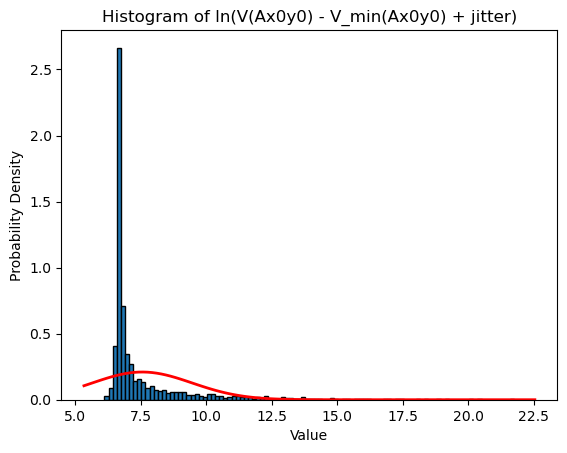

In [3]:
#Create histogram for V_scaled
# y = y_scaler.transform(y)
plt.hist(y, bins=100, density=True, edgecolor='black')  # Adjust the number of bins as needed
xmin, xmax = plt.xlim() 
mu, std = norm.fit(y[~np.isnan(y)])
print(mu, std)
x = np.linspace(xmin, xmax, 100) 
p = norm.pdf(x, mu, std) 
plt.plot(x, p, 'r', linewidth=2) 


# Add labels and title
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Histogram of ln(V(Ax0y0) - V_min(Ax0y0) + jitter)')

# Display the histogram
plt.show()

4.68**2 * Matern(length_scale=[1e+03, 1e+03, 1e+03, 24.4, 1e+03, 1e+03, 104, 4.04, 1e+03, 1e+03, 87.5, 4.05, 6.47, 4.96], nu=2.5) + WhiteKernel(noise_level=0.0001)
4.84**2 * Matern(length_scale=[1e+03, 1e+03, 1e+03, 24.8, 1e+03, 1e+03, 108, 4.1, 1e+03, 1e+03, 98, 4.22, 6.63, 5.14], nu=2.5) + WhiteKernel(noise_level=0.0001)
4.79**2 * Matern(length_scale=[1e+03, 1e+03, 1e+03, 24.8, 1e+03, 1e+03, 108, 4.08, 1e+03, 1e+03, 94.6, 4.12, 6.59, 5.16], nu=2.5) + WhiteKernel(noise_level=0.0001)
4.75**2 * Matern(length_scale=[1e+03, 1e+03, 1e+03, 24.4, 1e+03, 1e+03, 108, 4.07, 1e+03, 1e+03, 97.7, 4.17, 6.61, 5.15], nu=2.5) + WhiteKernel(noise_level=0.0001)
4.84**2 * Matern(length_scale=[1e+03, 1e+03, 1e+03, 24, 1e+03, 1e+03, 104, 4.01, 1e+03, 1e+03, 81.2, 4.14, 6.45, 5.02], nu=2.5) + WhiteKernel(noise_level=0.0001)
4.7**2 * Matern(length_scale=[1e+03, 1e+03, 1e+03, 25.9, 1e+03, 1e+03, 109, 4.04, 1e+03, 1e+03, 93.9, 4.14, 6.57, 5.12], nu=2.5) + WhiteKernel(noise_level=0.0001)
4.87**2 * Matern(lengt

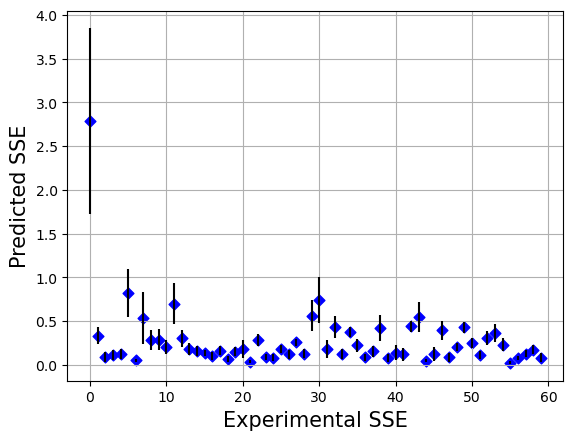

In [4]:
#Run LOO in theta
def LOO_theta(X, X_scaler, y, y_scaler, num_state_pts):
    n_samples = len(X)
    predict_mean = []
    predict_std = []
    for i in range(0, n_samples, num_state_pts):
        test_indices = np.arange(i, i + num_state_pts)
        X_leave_one = X[test_indices,:]
        y_leave_one = y[test_indices,:]

        X_rest = np.delete(X,test_indices,axis=0)
        y_rest = np.delete(y,test_indices,axis=0)

        X_scaled_train = X_scaler.transform(X_rest)
        y_scaled_train = y_rest
        # y_scaled_train = y_scaler.transform(y_rest)

        X_scaled_test = X_scaler.transform(X_leave_one)

        #fit GP model
        #build and train GP
        noise_std = 0.01
        retrain_GP =1
        seed = 1

        #Set noise kernel
        noise_kern = WhiteKernel(noise_level=noise_std**2, noise_level_bounds= "fixed") #bounds = "fixed"
        #Set Constant Kernel
        cont_kern = ConstantKernel(constant_value = 1, constant_value_bounds = (1e-3,1e4)) #(1e-3,1e4)
        #Create full kernel
        kernel = cont_kern*Matern(length_scale_bounds=(1e-03, 1e3), nu=2.5) + noise_kern #Matern Kernel
        #Set initial model lengthscale to 1
        kernel.k1.k2.length_scale = np.ones(X.shape[1])

        gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-4, n_restarts_optimizer=retrain_GP, 
                                            random_state = seed, optimizer = "fmin_l_bfgs_b", normalize_y = True)

        #Fit GP Model
        # print(X_scaled_train.shape, y_scaled_train.shape)
        gpr.fit(X_scaled_train, y_scaled_train)
        print(gpr.kernel_)

        #get mean, variance
        y_scaled_train_mean, y_scaled_train_std = gpr.predict(X_scaled_train, return_std=True)
        y_scaled_test_mean, y_scaled_test_std = gpr.predict(X_scaled_test, return_std=True)
        
        #inverse transform predicted result
        # y_train_mean = y_scaler.inverse_transform(y_scaled_train_mean.reshape(-1,1))
        # y_train_std = np.sqrt(y_scaler.var_) * y_scaled_train_std.reshape(-1,1)
        y_test_mean = y_scaled_test_mean.reshape(-1,1)
        y_test_std = y_scaled_test_std.reshape(-1,1)

        #Calc SSE given "True" values
        # print(y_test_mean, y_leave_one)
        SSE = np.sum((y_test_mean - y_leave_one)**2)
        errors = 2*(y_test_mean - y_leave_one)**2
        SSE_stdev = np.sqrt(errors.T@y_test_std**2)

        #record result
        predict_mean.append(SSE.flatten())
        predict_std.append(SSE_stdev.flatten())

    predict_mean = np.array(predict_mean)
    predict_std = np.array(predict_std)

    R2_score = r2_score(np.zeros(len(predict_mean)), predict_mean)

    # print(predict_mean)
    # print(predict_std)
    # print(R2_score)
    
    return R2_score, predict_mean, predict_std

R2_score, predict_mean, predict_std = LOO_theta(X, X_scaler, y, y_scaler, num_state_pts)

text = 'LOO-$R^2$ score: ' + str(np.round(R2_score,2))
plt.scatter(np.arange(len(predict_mean)), predict_mean, 30,c='b', marker='D', label='LOO-test point')
plt.errorbar(np.arange(len(predict_mean)), predict_mean.flatten(), predict_std.flatten(), c='k', fmt = ' ')

plt.xlabel('Experimental SSE',fontdict={'size':15})
plt.ylabel('Predicted SSE', fontdict={'size':15})
plt.grid(True)
plt.show()

LOO-$R^2$ score: 1.0


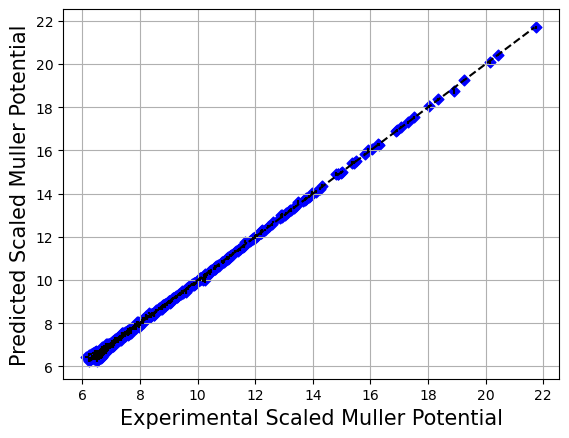

In [5]:
#Run LOO
def LOO(X, X_scaler, y, y_scaler):
    n_samples = len(X)
    predict_mean = []
    predict_std = []
    for i in range(n_samples):
        X_leave_one = X[i]
        y_leave_one = y[i]
        X_rest = np.delete(X,i,axis=0)
        y_rest = np.delete(y,i,axis=0)

        X_scaled_train = X_scaler.transform(X_rest)
        y_scaled_train = y_rest
        # y_scaled_train = y_scaler.transform(y_rest)

        X_scaled_test = X_scaler.transform(X_leave_one.reshape(1,-1))

        #fit GP model
        #build and train GP
        noise_std = 0.01
        retrain_GP =1
        seed = 1

        #Set noise kernel
        noise_kern = WhiteKernel(noise_level=noise_std**2, noise_level_bounds= "fixed") #bounds = "fixed"
        #Set Constant Kernel
        cont_kern = ConstantKernel(constant_value = 1, constant_value_bounds = (1e-3,1e4)) #(1e-3,1e4)
        #Create full kernel
        kernel = cont_kern*Matern(length_scale_bounds=(1e-03, 1e3), nu=2.5) + noise_kern #Matern Kernel
        #Set initial model lengthscale to 1
        kernel.k1.k2.length_scale = np.ones(X.shape[1])

        gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-4, n_restarts_optimizer=retrain_GP, 
                                            random_state = seed, optimizer = "fmin_l_bfgs_b", normalize_y = True)

        #Fit GP Model
        gpr.fit(X_scaled_train, y_scaled_train)

        #get mean, variance
        y_scaled_train_mean, y_scaled_train_std = gpr.predict(X_scaled_train, return_std=True)
        y_scaled_test_mean, y_scaled_test_std = gpr.predict(X_scaled_test, return_std=True)
        
        #inverse transform predicted result
        # y_train_mean = y_scaler.inverse_transform(y_scaled_train_mean.reshape(-1,1))
        # y_train_std = np.sqrt(y_scaler.var_) * y_scaled_train_std.reshape(-1,1)
        y_test_mean = y_scaled_test_mean.reshape(-1,1) 
        y_test_std = y_scaled_test_std.reshape(-1,1)

        #record result
        predict_mean.append(y_test_mean[0][0])
        predict_std.append(y_test_std[0][0])

    predict_mean = np.array(predict_mean)
    predict_std = np.array(predict_std)

    R2_score = r2_score(y, predict_mean)

    # print(predict_mean)
    # print(predict_std)
    # print(R2_score)
    
    return R2_score, predict_mean, predict_std

R2_score, predict_mean, predict_std = LOO(X, X_scaler, y, y_scaler)
text = 'LOO-$R^2$ score: ' + str(np.round(R2_score,2))
print(text)
plt.scatter(y, predict_mean, 30,c='b', marker='D', label='LOO-test point')
plt.errorbar(y, predict_mean, predict_std, c='k', fmt = ' ')

plt.plot([np.amin(predict_mean),np.amax(predict_mean)],[np.amin(predict_mean),np.amax(predict_mean)],'k--', label='parity line')
plt.xlabel('Experimental Scaled Muller Potential',fontdict={'size':15})
plt.ylabel('Predicted Scaled Muller Potential', fontdict={'size':15})
plt.grid(True)
plt.show()